# RESCAL vs BayesianRESCAL on KINSHIP dataset

## 1. Bayesian RESCAL model

Here's the generative process of triple (entity, relation, entity):

For each entity $i$, a latent representation of the entity $e_i \in \mathbb{R}^{D}$ is drawn from the zero mean multivariate-normal distribution with diagonal covariance matrix:

$$e_i \sim N(0, \sigma_e^2 I_D)$$

For each relation $k$, relation matrix $R_k \in \mathbb{R}^{D\times D}$ is drawn from the matrix normal distribution with diagonal covariance matrices:

$$R_k \sim MN(0, \sigma_r^2 I_D, I_D)$$

For each triple $(i, k, j)$, the observed value of the triple $x_{i,k,j}$ is drawn from the normal distribution with bilinear mean and variance:

$$x_{ikj} \sim N(e_i^\top R_k e_j, \sigma_x^2)$$


In [1]:
import numpy as np
import logging
from scipy.io.matlab import loadmat
from scipy.sparse import csr_matrix
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import rescal
from brescal import BayesianRescal

%matplotlib inline

#logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)

In [2]:
dataset = 'kinship'
mat = loadmat('../data/%s/alyawarradata.mat' % (dataset))
T = np.array(mat['Rs'], np.float32)

max_iter = 20

n_dim = 10
T = np.swapaxes(T, 1, 2)
T = np.swapaxes(T, 0, 1)  # [relation, entity, entity]
n_relation, n_entity, _ = T.shape
print(T.shape)

(26, 104, 104)


## 2. Splitting the kinship dataset into train/test sets

`trainT` only contains a partial observation of the original tensor `T`

In [3]:
import itertools
trainT = np.zeros_like(T)
p = 0.1

train_mask = np.random.binomial(1, p, T.shape)
trainT[train_mask==1] = T[train_mask==1]
test_mask = np.ones_like(T)
test_mask[train_mask==1] = 0
print('training size %d' % np.sum(trainT))
print('test size %d' % np.sum(T[test_mask==1]))

training size 1036
test size 9754


## 3. Training BayesianRESCAL

### 3.1. Grid search on variance parameters

Compare performances of different configuration of variances

#### <font color='red'>RESULT(GRID SEARCH)</font>: BayesianRESCAL does not work well when variance of x is equal or larger than 1

In [4]:
var_list = [0.01, 0.001]
var_e = 1
var_r = 1
best_roc = 0
for var_x in var_list:
    model = BayesianRescal(n_dim, var_e=var_e, var_x=var_x, var_r=var_r)
    model.fit(trainT, max_iter=max_iter)
    _T = model._reconstruct()
    score = roc_auc_score(T[test_mask==1], _T[test_mask==1])
    print('var_x:{0:3.3f}, var_e:{1:3.3f}, var_r:{2:3.3f}, AUC-ROC:{3:.3f}'.format(var_x, var_e, var_r, score))
    if score > best_roc:
        best_vars = (var_x, var_e, var_r)
        best_model = model
        best_roc = score

var_x, var_e, var_r = best_vars
print(best_vars)

var_x:0.010, var_e:1.000, var_r:1.000, AUC-ROC:0.798
var_x:0.001, var_e:1.000, var_r:1.000, AUC-ROC:0.872
(0.001, 1, 1)


### 3.2. Training RESCAL

In [5]:
X = list()
for k in range(n_relation):
    X.append(csr_matrix(trainT[k]))
    
A, R, f, itr, exectimes = rescal.rescal_als(X, n_dim)

### 3.3. Compare both models by ROC-AUC

#### <font color='red'>RESULT</font>: BayesianRESCAL is comparable with RESCAL

#### ROC-AUC score of BRESCAL

In [6]:
_T = best_model._reconstruct()
print(roc_auc_score(T[test_mask==1], _T[test_mask==1]))

0.871707853872


#### ROC-AUC score of RESCAL

In [7]:
_X = np.zeros_like(T)
for k in range(T.shape[0]):
    _X[k] = np.dot(np.dot(A, R[k]), A.T)
print(roc_auc_score(T[test_mask==1], _X[test_mask==1]))

0.87840503508


## 4. Initialize Bayesian_RESCAL with RESCAL

Let's see that Bayesian_RESCAL performs worse than RESCAL because it can't escape from local optimum.

In [8]:
A, R, f, itr, exectimes = rescal.rescal_als(X, n_dim)
model = BayesianRescal(n_dim, var_e=var_e, var_x=var_x, var_r=var_r)
model.n_relations = n_relation
model.n_entities = n_entity
model.E = A
model.R = np.zeros([n_relation, n_dim, n_dim])
for k in range(n_relation):
    model.R[k] = R[k]
model._gibbs(trainT, max_iter=5)

#### ROC-AUC score of BRESCAL initialized by RESCAL

In [9]:
_T = model._reconstruct()
print(roc_auc_score(T[test_mask==1], _T[test_mask==1]))

0.852329532385


## 5. Place difference variances on observed / unobserved data points

I adopt idea from implicit feedback approach from the following paper in which they place a different variance on observed/unobserved variables (variance of observed variable is smaller than those of unobserved):

*Collaborative Filtering for Implicit Feedback Datasets, Yifan Hu, et al. ICDM2008*

#### <font color='red'>RESULT</font>: BayesianRESCAL with controlled variance (CV_BRESCAL) performs slightly better than BRESCAL.

In [10]:
observed_var = 0.001
unobserved_var = 1.
n_trial = 1
for i in range(n_trial):
    model = BayesianRescal(n_dim, var_e=var_e, var_x=var_x, var_r=var_r, controlled_var=True, 
                           obs_var=observed_var, unobs_var=unobserved_var)
    model.fit(trainT, max_iter=max_iter)
    _T = model._reconstruct()
    print(roc_auc_score(T[test_mask==1], _T[test_mask==1]))

0.879965167208


In [11]:
observed_var = 0.01
unobserved_var = 1.
for i in range(n_trial):
    model = BayesianRescal(n_dim, var_e=var_e, var_x=var_x, var_r=var_r, controlled_var=True, 
                           obs_var=observed_var, unobs_var=unobserved_var)
    model.fit(trainT, max_iter=max_iter)
    _T = model._reconstruct()
    print(roc_auc_score(T[test_mask==1], _T[test_mask==1]))

0.932805011012


In [12]:
observed_var = 0.001
unobserved_var = 10.
for i in range(n_trial):
    model = BayesianRescal(n_dim, var_e=var_e, var_x=var_x, var_r=var_r, controlled_var=True, 
                           obs_var=observed_var, unobs_var=unobserved_var)
    model.fit(trainT, max_iter=max_iter)
    _T = model._reconstruct()
    print(roc_auc_score(T[test_mask==1], _T[test_mask==1]))

0.755790573864


In [13]:
observed_var = 0.001
unobserved_var = 100.
for i in range(n_trial):
    model = BayesianRescal(n_dim, var_e=var_e, var_x=var_x, var_r=var_r, controlled_var=True, 
                           obs_var=observed_var, unobs_var=unobserved_var)
    model.fit(trainT, max_iter=max_iter)
    _T = model._reconstruct()
    print(roc_auc_score(T[test_mask==1], _T[test_mask==1]))

0.549421288247


## A. Parameter optimization for RESCAL

RESCAL also has some parameters to be tuned.

#### <font color='red'>RESULT</font>: RESCAL is highly robust w.r.t the parameters...

In [38]:
var_list = [0.001, 0.01, 0.1, 1., 10., 100.]
best_roc = 0
for (var_x, var_e, var_r) in itertools.product(var_list,repeat=3):
    A, R, f, itr, exectimes = rescal.rescal_als(X, n_dim, lambda_A=var_x, lambda_R=var_e, lambda_V=var_r)
    _X = np.zeros_like(T)
    for k in range(T.shape[0]):
        _X[k] = np.dot(np.dot(A, R[k]), A.T)
    score = roc_auc_score(T.flatten(), _X.flatten())
    print('var_x:{0:3.3f}, var_e:{1:3.3f}, var_r:{2:3.3f}, AUC-ROC:{3:.3f}'.format(var_x, var_e, var_r, score))
    if score > best_roc:
        best_vars = (var_x, var_e, var_r)
        best_model = model
        best_roc = score
        
lambda_a, lambda_r, lambda_v = best_vars
print(best_vars, best_roc)

var_x:0.001, var_e:0.001, var_r:0.001, AUC-ROC:0.944
var_x:0.001, var_e:0.001, var_r:0.010, AUC-ROC:0.944
var_x:0.001, var_e:0.001, var_r:0.100, AUC-ROC:0.944
var_x:0.001, var_e:0.001, var_r:1.000, AUC-ROC:0.944
var_x:0.001, var_e:0.001, var_r:10.000, AUC-ROC:0.944
var_x:0.001, var_e:0.001, var_r:100.000, AUC-ROC:0.944
var_x:0.001, var_e:0.010, var_r:0.001, AUC-ROC:0.944
var_x:0.001, var_e:0.010, var_r:0.010, AUC-ROC:0.944
var_x:0.001, var_e:0.010, var_r:0.100, AUC-ROC:0.944
var_x:0.001, var_e:0.010, var_r:1.000, AUC-ROC:0.944
var_x:0.001, var_e:0.010, var_r:10.000, AUC-ROC:0.944
var_x:0.001, var_e:0.010, var_r:100.000, AUC-ROC:0.944
var_x:0.001, var_e:0.100, var_r:0.001, AUC-ROC:0.944
var_x:0.001, var_e:0.100, var_r:0.010, AUC-ROC:0.944
var_x:0.001, var_e:0.100, var_r:0.100, AUC-ROC:0.944
var_x:0.001, var_e:0.100, var_r:1.000, AUC-ROC:0.944
var_x:0.001, var_e:0.100, var_r:10.000, AUC-ROC:0.944
var_x:0.001, var_e:0.100, var_r:100.000, AUC-ROC:0.944
var_x:0.001, var_e:1.000, var_r:0.001

## For paper

In [ ]:
import numpy as np
import os
import itertools
from scipy.sparse import csr_matrix
import logging
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

import rescal
from brescal import BayesianRescal
from runner import load_dataset
from seq_brescal import PFBayesianRescal
from seq_logit_brescal import PFBayesianLogitRescal

%matplotlib inline

logger = logging.getLogger()
for handler in logger.handlers:
    logger.removeHandler(handler)


datasets = ['kinship', 'umls', 'nation']

result = dict()
train_test_validation = dict()
n_trial = 10
max_iter = 20
n_dim = 10

models = ['rescal', 'brescal', 'blogit']
for dataset in datasets:
    train_test_validation[(dataset)] = list()
    
for model, dataset in itertools.product(models, datasets):
    result[(dataset, model)] = list()

if not os.path.exists('../result/rescal_vs_brescal.pkl'):
    for nt in range(n_trial):
        tic = time.time()

        for dataset in datasets:
            T = load_dataset(dataset)
            n_relation, n_entity, _ = T.shape

            samples = [(i, j, k) for i, j, k in itertools.product(range(n_relation), range(n_entity), range(n_entity))]
            total = np.prod(T.shape)
            np.random.shuffle(samples)
            train_p = 0.1
            validation_p = 0.3
            test_p = 1. - validation_p - train_p
            train_test_validation[dataset].append(samples)

            train_mask = np.zeros_like(T)
            validation_mask = np.zeros_like(T)
            test_mask = np.zeros_like(T)
            for idx in range(int(total * train_p)):
                i, j, k = samples[idx]
                train_mask[i, j, k] = 1
            for idx in range(int(total * validation_p)):
                i, j, k = samples[int(total * train_p) + idx]
                validation_mask[i, j, k] = 1
            for idx in range(int(total * test_p)):
                i, j, k = samples[int(total * train_p) + int(total * validation_p) + idx]
                test_mask[i, j, k] = 1

            trainT = np.zeros_like(T)
            trainT[train_mask == 1] = T[train_mask == 1]


            lambda_As = [0.01, 0.1, 1.]
            lambda_Rs = [0.01, 0.1, 1.]
            best_roc = 0
            for lambda_A, lambda_R in itertools.product(lambda_As, lambda_Rs):
                X = list()
                for k in range(n_relation):
                    X.append(csr_matrix(trainT[k]))
                A, R, f, itr, exectimes = rescal.rescal_als(X, n_dim, lambda_A=lambda_A, lambda_R=lambda_R)
                _X = np.zeros_like(T)
                for k in range(T.shape[0]):
                    _X[k] = np.dot(np.dot(A, R[k]), A.T)
                score = roc_auc_score(T[validation_mask == 1], _X[validation_mask == 1])
                if score > best_roc:
                    best_vars = (lambda_A, lambda_R)
                    best_A, best_R = A, R
                    best_roc = score

            _X = np.zeros_like(T)
            for k in range(T.shape[0]):
                _X[k] = np.dot(np.dot(best_A, best_R[k]), best_A.T)
            score = roc_auc_score(T[test_mask == 1], _X[test_mask == 1])
            print('RESCAL', dataset, best_vars, score)
            result[(dataset, models[0])].append(score)
            
            
            var_list = [0.001, 0.01, 0.1]
            var_e = 1
            var_r = 1
            best_roc = 0
            for var_x in var_list:
                _model = PFBayesianRescal(n_dim, var_x=var_x, n_particles=1, compute_score=False,
                                          parallel=False, sample_all=True)
                seq = _model.fit(T, obs_mask=train_mask.copy(), max_iter=0)
                _T = _model._reconstruct(_model.E[0], _model.R[0])
                score = roc_auc_score(T[validation_mask == 1], _T[validation_mask == 1])
                if score > best_roc:
                    best_vars = (var_x, var_e, var_r)
                    best_model = _model
                    best_roc = score

            _T = best_model._reconstruct(best_model.E[0], best_model.R[0])
            score = roc_auc_score(T[test_mask == 1], _T[test_mask == 1])
            print('BRESCAL', dataset, best_vars, score)
            result[(dataset, models[1])].append(score)


    #         observed_vars = [0.01, 0.001]
    #         unobserved_vars = [1., 10.]
    #         best_roc = 0
    #         for observed_var, unobserved_var in itertools.product(observed_vars, unobserved_vars):
    #             model = BayesianRescal(n_dim, var_e=var_e, var_r=var_r, controlled_var=True,
    #                                    obs_var=observed_var, unobs_var=unobserved_var)
    #             model.fit(trainT, max_iter=max_iter)
    #             _T = model._reconstruct()
    #             score = roc_auc_score(T[validation_mask == 1], _T[validation_mask == 1])
    #             if score > best_roc:
    #                 best_vars = (observed_var, unobserved_var)
    #                 best_model = model
    #                 best_roc = score

    #         _T = best_model._reconstruct()
    #         score = roc_auc_score(T[test_mask == 1], _T[test_mask == 1])
    #         print('BRESCAL_CTRL', dataset, score)
    #         result[(dataset,'brescal_ctrl')].append(score)


            _model = PFBayesianLogitRescal(n_dim, n_particles=1, compute_score=False)
            seq = _model.fit(T, obs_mask=train_mask.copy(), max_iter=0)
            particle = _model.p_weights.argmax()
            _T = _model._reconstruct(_model.E[0], _model.R[0])
            score = roc_auc_score(T[test_mask == 1], _T[test_mask == 1])
            print('BRESCAL_LOGIT', dataset, score)
            result[(dataset, models[2])].append(score)

        print(time.time() - tic)

    pickle.dump([result, train_test_validation], open('../result/rescal_vs_brescal.pkl', 'wb'))

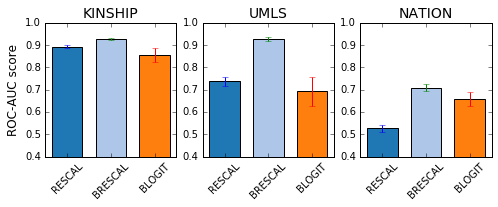

In [80]:
result, samples = pickle.load(open('../result/rescal_vs_brescal.pkl', 'rb'))

plt.figure(figsize=(8, 2.4))
width = 1
title_size = 14
label_size = 12

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

for plt_no, dataset in enumerate(datasets):
    plt.subplot(1, len(datasets), plt_no+1)

    for model in models:
        mean = np.mean(result[(dataset,model)])
        std = np.std(result[(dataset,model)])
        label = model.upper()
        if model == 'brescal_logit':
            label = 'BLOGIT'
        plt.bar(models.index(model)+0.15, mean, width-0.3, color=tableau20[models.index(model)], yerr=std, label=label)
    plt.xticks(np.arange(len(models))+0.50, ['%s'% (model.upper()) for model in models], rotation=45)

    if plt_no == 0:
#        plt.legend(loc='lower left')        
#        plt.setp(plt.gca().get_legend().get_texts(), fontsize='10')
        plt.ylabel('ROC-AUC score', size=label_size)


#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom='off',      # ticks along the bottom edge are off
#         top='off',         # ticks along the top edge are off
#         labelbottom='off') # labels along the bottom edge are off

    plt.title('%s' % dataset.upper(), size=title_size)
    plt.ylim((0.4,1))

# plt.savefig('../paper/images/rescal_vs_brescal.pdf', format='PDF', bbox_inches='tight', pad_inches=0.1)
plt.show()